# Galaxy classification with Convolutional Neural Networks
In this tutorial we build a CNN to perform Galaxy classification.
The dataset comes from the Galaxy Zoo Challenge and it is publicy available here:

https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge

and described here:

http://arxiv.org/abs/1308.3496

The original dataset include more than 60,000 galaxy images, classified in 37 classes.

Here we use a simplified version of it, which include 6167 Galaxies classified in 3 classes: Round, Disk edge-on or Spiral.

To build, train and test the CNN we use keras with the tensorflow backend. 
Below we import the necessary modules.

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

load the file with the original classification of the full galaxy zoo dataset and print a subsection of it

In [4]:
df = pd.read_csv('./training_solutions_rev1.csv')

In [5]:
df[0:10]

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.000000,0.000000,0.000000,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.000000,0.000000,0.000000,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.000000,0.000000,0.000000,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,100122,0.738832,0.238159,0.023009,0.000000,0.238159,0.000000,0.238159,0.000000,0.238159,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,100123,0.462492,0.456033,0.081475,0.000000,0.456033,0.000000,0.456033,0.000000,0.456033,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,100128,0.687783,0.288344,0.023873,0.000000,0.288344,0.069098,0.219246,0.000000,0.288344,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,100134,0.021834,0.976952,0.001214,0.021751,0.955201,0.313077,0.642124,0.546491,0.408711,...,0.021751,0.207253,0.152044,0.187194,0.000000,0.000000,0.054649,0.081974,0.081974,0.327894
9,100143,0.269843,0.730157,0.000000,0.730157,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.168728,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


some functions to load the original images (not used in this tutorial as the simplified version of the datasets has been already prepared)

In [6]:
ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)

def get_image(path, x1, y1, shape, crop_size):
    x = plt.imread(path)
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    x = x/255.
    return x
    
def get_all_images(dataframe, shape=IMG_SHAPE, crop_size=CROP_SIZE):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
   
    sel = dataframe.values
    ids = sel[:,0].astype(int).astype(str)
    y_batch = sel[:,1:]
    x_batch = []
    for i in tqdm(ids):
        x = get_image('./images_training_rev1/'+i+'.jpg', x1,y1, shape=shape, crop_size=crop_size)
        x_batch.append(x)
    x_batch = np.array(x_batch)
    return x_batch, y_batch

def get_labels(dataframe):
    sel = dataframe.values
    ids = sel[:,0].astype(int).astype(str)
    y_batch = sel[:,1:]
    return y_batch

load already prepared simplified dataset, images in the X array, labels in the y array

**Note**: the file *sel_data.npz* with the needed galaxy images should be downloaded from here:
https://www.dropbox.com/s/b723my0vghjdo9a/sel_data.npz?dl=0

In [17]:
data = np.load('sel_data.npz')
X = data['X']
y = data['y']

In [18]:
print(X.shape, y.shape)

(6167, 64, 64, 3) (6167, 3)


plot a random image of the dataset together with its class

In [19]:
def print_class(y):
    gal_class = np.argmax(y)
    if gal_class==0:
        print('This is a round Galaxy')
    if gal_class==1:
        print('This is a Galaxy with disk edge-on')
    if gal_class==2:
        print('This is a spiral Galaxy')

This is a spiral Galaxy


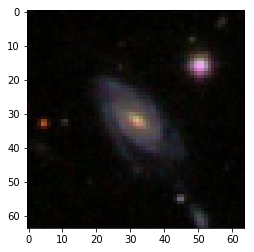

In [20]:
t = np.random.randint(len(X))
plt.imshow(X[t]*255)
print_class(y[t])

Divide dataset into training (80%), validation (10%) and test set (10%)

In [21]:
Ntot = len(X)
tot_ind = np.arange(Ntot)
train_ind = np.random.randint(0, Ntot, int(Ntot*0.8))
tot_ind = np.delete(tot_ind, train_ind)
val_ind = np.random.choice(tot_ind,int(len(tot_ind)/2))
test_ind = np.delete(tot_ind, val_ind)

/Users/niki/Library/miniconda3/envs/py36n/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  


In [22]:
X_train = X[train_ind]
y_train = y[train_ind]
X_val = X[val_ind]
y_val = y[val_ind]
X_test = X[test_ind]
y_test = y[test_ind]

Build the CNN, compile and train/validate it

In [23]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 16)        1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        25664     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         204928    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
__________

**Note:** training should be done on GPUs, if you are not running on GPUs skip this part and load the pretrained model

In [26]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

cnn_history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=1,
          verbose=1, validation_data=(X_val, y_val))

Train on 4933 samples, validate on 1380 samples
Epoch 1/1
4933/4933 [==============================] - 30s 6ms/step - loss: 0.9144 - acc: 0.4885 - val_loss: 0.9163 - val_acc: 0.5522


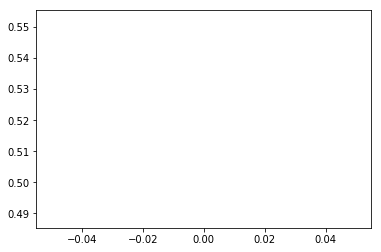

In [27]:
plt.plot(cnn_history.history['acc'])
plt.plot(cnn_history.history['val_acc'])

In [28]:
model = load_model('pretrained_CNN.h5')

In [29]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])
y_pred_cnn2 = model.predict(X_test)

Test accuracy: 0.9506666666666667


This is a spiral Galaxy


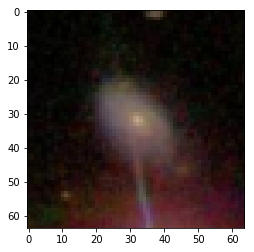

In [30]:
t = np.random.randint(len(X_test))
plt.imshow(X_test[t, :, :]*255)
print_class(y_pred_cnn2[t])

Save and reload the trained model

In [31]:
#model.save('pretrained_CNN.h5')
#model = load_model('pretrained_CNN.h5')

some inspection...

we extract from the trained neural network the values of weights in each filter and plot them

In [32]:
conv1_lyr = model.layers[0]

In [33]:
w_conv1 = conv1_lyr.get_weights()

In [34]:
w_conv1 = np.array(w_conv1)

In [35]:
w_conv1[0].shape

(5, 5, 3, 16)

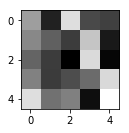

In [36]:
plt.subplot(132)
plt.imshow(w_conv1[0][:,:,1,2], cmap='binary')